In [8]:
%%javascript
utils.load_extension("execute_time/ExecuteTime")
utils.load_extension('collapsible_headings/main') 

<IPython.core.display.Javascript object>

In [7]:
# %%
# Import candidate models
import warnings
import pdb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor

# Import datasets
from doubt.datasets import (
    Airfoil,
    Blog,
    Concrete,
    CPU,
    FacebookComments,
    FishBioconcentration,
    FishToxicity,
    ForestFire,
    NewTaipeiHousing,
    PowerPlant,
    Protein,
    Servo,
    SpaceShuttle,
    Yacht,
)

# Import external libraries
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import shap

import matplotlib.pyplot as plt
from matplotlib import rcParams

plt.style.use("seaborn-whitegrid")
rcParams["axes.labelsize"] = 14
rcParams["xtick.labelsize"] = 12
rcParams["ytick.labelsize"] = 12
rcParams["figure.figsize"] = 16, 8
plt.rcParams["figure.figsize"] = [10, 5]


from collections import defaultdict
from utils import initialise_plot



In [14]:

# %%
dataset_classes = [
    Airfoil,
    Concrete,
    #FishToxicity,
    #ForestFire,
    #NewTaipeiHousing,
    #PowerPlant,
    # Protein,
    # Servo,
]
for dataset in dataset_classes:
    print(dataset().shape)
# %%


(1503, 6)
(1030, 9)


In [15]:
def monitoring_plot(
    dataset,
    base_regressor: type,
    agnostic: bool = False,
    rolling: bool = True,
    ROLLING_STAT: int = 100,
    **kwargs,
):

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        # Initialise the scaler
        standard_scaler = StandardScaler()

        # Load the dataset and split it
        X, _, y, _ = dataset().split(test_size=0.001, random_seed=4242)

        # Scale the dataset
        X = standard_scaler.fit_transform(X)

        # Back to dataframe
        X = pd.DataFrame(X, columns=["Var %d" % (i + 1) for i in range(X.shape[1])])
        data = X.copy()
        data["target"] = y

        # Train test splitting points
        fracc = 0.33
        oneThird = int(data.shape[0] * fracc)
        twoThird = data.shape[0] - int(data.shape[0] * fracc)
        print(
            "Number of rows {}, 1split {}, 2nd split {}".format(
                data.shape[0], oneThird, twoThird
            )
        )

        # Initialize plots
        num_rows = X.shape[1] // 3
        if X.shape[1] % 3 > 0:
            num_rows += 1
        fig, axs = initialise_plot(
            num_rows=num_rows,
            num_cols=3,
            base_regressor=base_regressor,
            dataset=dataset,
        )

        shap_res = []

        for idx, col in tqdm(enumerate(X.columns), total=len(X.columns)):
            values = defaultdict(list)

            # Sort data on the column
            data = data.sort_values(col).reset_index(drop=True).copy()

            # Train Test Split
            data_sub = data.iloc[:oneThird]
            data_train = data.iloc[oneThird:twoThird]
            data_up = data.iloc[twoThird:]

            X_tot = data.drop(columns="target")
            X_tr = data_train.drop(columns="target")
            X_sub = data_sub.drop(columns="target")
            X_up = data_up.drop(columns="target")

            y_tot = data[["target"]].target.values
            y_tr = data_train[["target"]].target.values
            y_sub = data_sub[["target"]].target.values
            y_up = data_up[["target"]].target.values

            # Fit the regressor
            regressor = base_regressor()
            regressor.fit(X_tr, y_tr)

            # Predictions
            preds = regressor.predict(X_tot)

            # explain the model's predictions using SHAP
            if agnostic:
                # use Kernel SHAP to explain test set predictions
                explainer = shap.KernelExplainer(regressor.predict, X_tot)
                shap_values = explainer.shap_values(X_tot, nsamples=100)
                shap_values = pd.DataFrame(data=shap_values, columns=X_tot.columns)
            else:
                # use Decision Tree specific SHAP to explain
                explainer = shap.Explainer(regressor)
                shap_values = explainer(X_tot)
                shap_values = pd.DataFrame(
                    data=shap_values.values, columns=X_tot.columns
                )

            # Statistics
            df = pd.DataFrame(np.abs(preds - y_tot), columns=["error"])

            ## TODO: NOT SURE ABOUT THIS ABSOLUTE VALUE THINGY
            df["mean_shap"] = np.mean(np.abs(shap_values), axis=1)
            df["shap_diff"] = np.abs(df["mean_shap"] - df["error"])
            shap_res.append(np.mean(df.shap_diff.values))

            ### Rolling window on all
            if rolling:
                ROLLING_STAT = 100
                df = df.rolling(ROLLING_STAT, int(ROLLING_STAT * 0.5)).mean().dropna()

            ## Scaling
            df = df.dropna()
            df = pd.DataFrame(standard_scaler.fit_transform(df), columns=df.columns)

            # Convert to dic for plotting
            for index, col in enumerate(df[["error", "shap_diff"]].columns):
                values[col] = df[col]
            # Plotting
            for name, vals in values.items():
                if idx == 0:
                    axs[idx // 3, idx % 3].plot(vals, label=f"{name} values")
                else:
                    axs[idx // 3, idx % 3].plot(vals, label=f"{name} values")


        # plt.savefig("fig.png")
        print(dataset.__name__)
        print(np.mean(shap_res))

No handles with labels found to put in legend.


Number of rows 1501, 1split 495, 2nd split 1006


  0%|          | 0/5 [00:00<?, ?it/s]

No handles with labels found to put in legend.


Airfoil
2.3388378590849546
Number of rows 1028, 1split 339, 2nd split 689


  0%|          | 0/8 [00:00<?, ?it/s]

Concrete
4.890481878531601


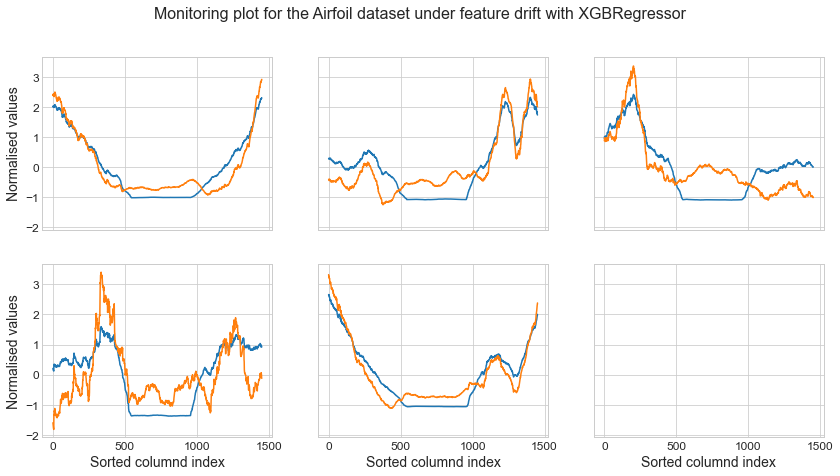

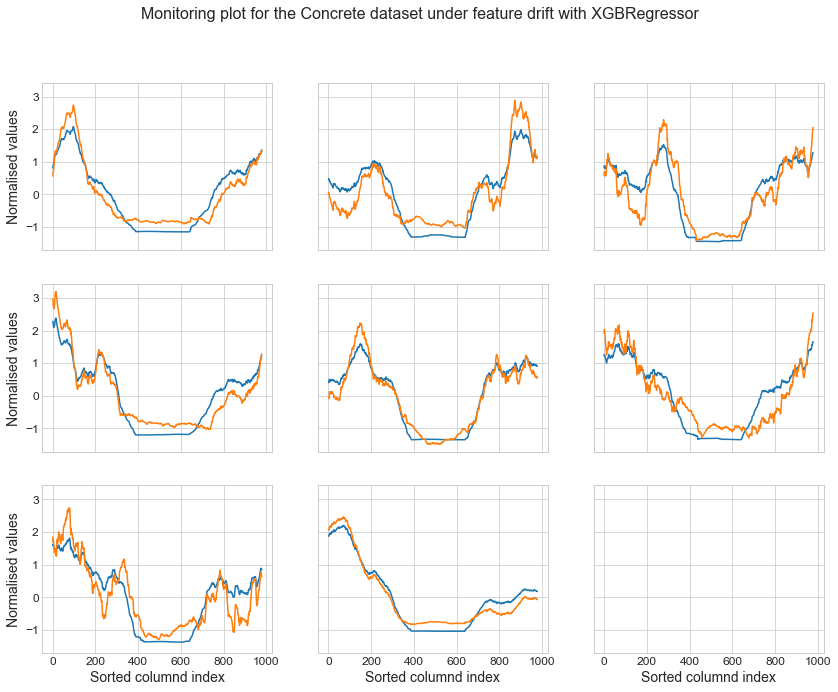

In [16]:
for dataset in dataset_classes:
    a = monitoring_plot(dataset, XGBRegressor, agnostic=False)

Number of rows 1501, 1split 495, 2nd split 1006


No handles with labels found to put in legend.


  0%|          | 0/5 [00:00<?, ?it/s]

Using 1501 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1501 [00:00<?, ?it/s]

Using 1501 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1501 [00:00<?, ?it/s]

Using 1501 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1501 [00:00<?, ?it/s]

Using 1501 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1501 [00:00<?, ?it/s]

Using 1501 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1501 [00:00<?, ?it/s]

Airfoil
2.362243149997943
Number of rows 1028, 1split 339, 2nd split 689


No handles with labels found to put in legend.


  0%|          | 0/8 [00:00<?, ?it/s]

Using 1028 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1028 [00:00<?, ?it/s]

Using 1028 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1028 [00:00<?, ?it/s]

Using 1028 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1028 [00:00<?, ?it/s]

Using 1028 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1028 [00:00<?, ?it/s]

Using 1028 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1028 [00:00<?, ?it/s]

Using 1028 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1028 [00:00<?, ?it/s]

Using 1028 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1028 [00:00<?, ?it/s]

Using 1028 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1028 [00:00<?, ?it/s]

Concrete
4.944602731088667


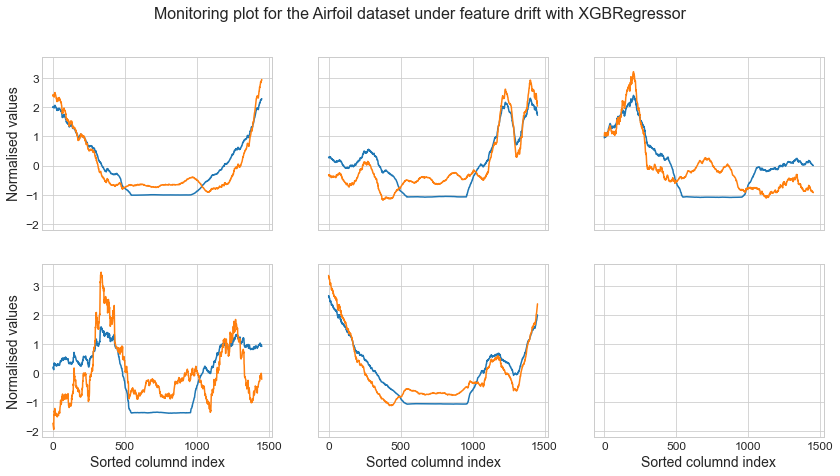

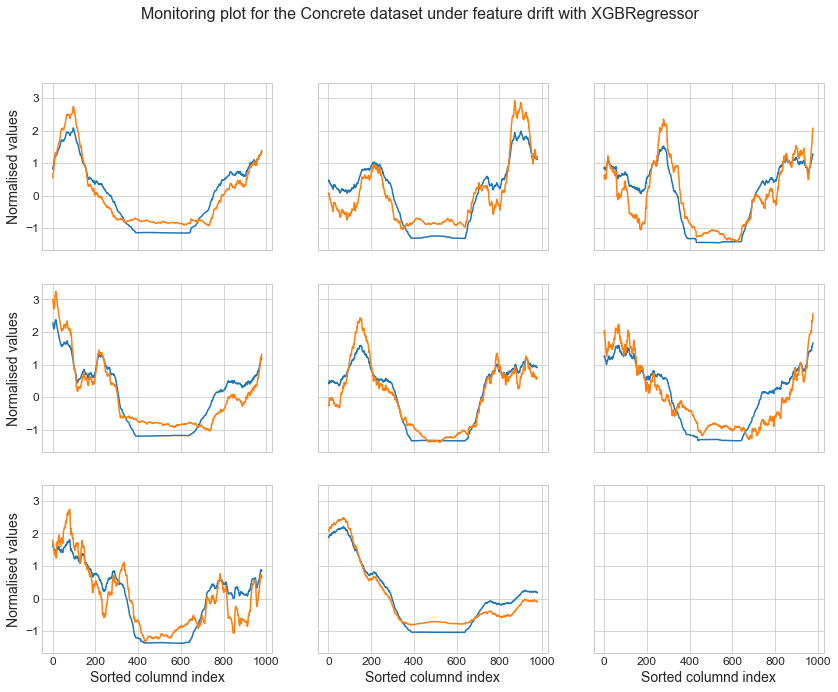

In [17]:
for dataset in dataset_classes:
    a = monitoring_plot(dataset, XGBRegressor, agnostic=True)

In [21]:
dataset.__name__

'NewTaipeiHousing'

In [ ]:
# Taipei
4.94,5.06
# Airfoil
2.33,2.36
# Concrete
4.89,4.94

FixedFormatter should only be used together with FixedLocator


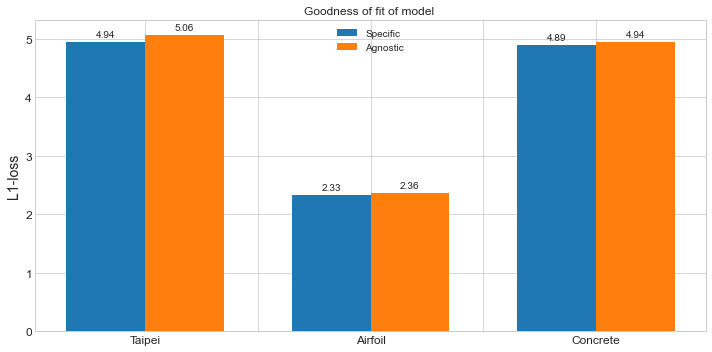

In [19]:
import matplotlib.pyplot as plt
import numpy as np


labels = ['Taipei', 'Airfoil', 'Concrete']
men_means = [4.94,2.33,4.89]
women_means = [5.06,2.36,4.94]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, men_means, width, label='Specific')
rects2 = ax.bar(x + width/2, women_means, width, label='Agnostic')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('L1-loss')
ax.set_title('Goodness of fit of model ')


ax.set_xticklabels(['','Taipei','','Airfoil','','Concrete'])

ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

In [55]:
print(shap.__version__)

0.39.0


In [10]:
X, _, y, _ = dataset().split(test_size=0.001, random_seed=4242)

Using 1501 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/5 [00:00<?, ?it/s]

In [23]:
# Back to dataframe
X = pd.DataFrame(X, columns=["Var %d" % (i + 1) for i in range(X.shape[1])])
data = X.copy()
data["target"] = y

        # Train test splitting points
fracc = 0.33
oneThird = int(data.shape[0] * fracc)
twoThird = data.shape[0] - int(data.shape[0] * fracc)



shap_res = []

for idx, col in tqdm(enumerate(X.columns), total=len(X.columns)):
            values = defaultdict(list)

            # Sort data on the column
            data = data.sort_values(col).reset_index(drop=True).copy()

            # Train Test Split
            data_sub = data.iloc[:oneThird]
            data_train = data.iloc[oneThird:twoThird]
            data_up = data.iloc[twoThird:]

            X_tot = data.drop(columns="target")
            X_tr = data_train.drop(columns="target")
            X_sub = data_sub.drop(columns="target")
            X_up = data_up.drop(columns="target")

            y_tot = data[["target"]].target.values
            y_tr = data_train[["target"]].target.values
            y_sub = data_sub[["target"]].target.values
            y_up = data_up[["target"]].target.values

  0%|          | 0/5 [00:00<?, ?it/s]

In [24]:
xgb = XGBRegressor().fit(X_tr,y_tr)

In [42]:
# use Kernel SHAP to explain test set predictions
explainer = shap.KernelExplainer(xgb.predict, X_tot)
shap_values = explainer.shap_values(X_tot[0:5], nsamples=100)

Using 1501 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/5 [00:00<?, ?it/s]

In [43]:
shap_values

array([[  0.26953283,  -1.94319922,   1.99085768,   1.70553958,
          2.01973289],
       [ -9.43679359,  -1.36484664,   1.39225542,   1.1147633 ,
          1.564487  ],
       [-12.47346954,  -1.94753269,   2.2763524 ,   1.16746938,
          1.32519384],
       [ -2.09335504,  -1.97712565,   1.61348293,   1.61878301,
          1.6758674 ],
       [  2.33386655,  -1.60721306,   2.1545441 ,   2.05040814,
          1.71016223]])